In [1]:
!pip install livelossplot --quiet

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from livelossplot import PlotLosses

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [47]:
# train_set = np.load('drive/MyDrive/EDVAM/train.npy')
train_set = np.load('drive/MyDrive/EDVAM/train_slim.npy') # first 10 features
train_label = np.load('drive/MyDrive/EDVAM/train_label.npy')

# test_set = np.load('drive/MyDrive/EDVAM/test.npy')
test_set = np.load('drive/MyDrive/EDVAM/test_slim.npy') # first 10 features 
test_label = np.load('drive/MyDrive/EDVAM/test_label.npy')

In [48]:
train_set.shape

(190830, 300, 10)

In [49]:
maxes = np.max([np.max(test_set, axis=0)[0], np.max(train_set, axis=0)[0]], axis=0)
mins = np.min([np.min(test_set, axis=0)[0], np.min(train_set, axis=0)[0]], axis=0)

min_max_range = maxes - mins

In [50]:
train_set = (train_set - mins) / min_max_range
test_set = (test_set - mins) / min_max_range

In [51]:
time_samples = [i for i in range(0, 150, 6)] + [i for i in range(150, 240, 5)] + \
               [i for i in range(240, 290, 2)] + [i for i in range(290, 300)]
features = [i for i in range(10)]

# time_samples = [i for i in range(290,300)]
features = [i for i in range(6)]

In [52]:
end_confidences = np.mean(train_set[:, [i for i in range(290, 300)], 9], axis=1)
confident_train = end_confidences > 0.7

end_confidences = np.mean(test_set[:, [i for i in range(290, 300)], 9], axis=1)
confident_test = end_confidences > 0.7

In [53]:
train_set = train_set[confident_train]
train_label = train_label[confident_train]
test_set = test_set[confident_test]
test_label = test_label[confident_test]

In [54]:
print(train_set.shape, test_set.shape)

(71439, 300, 10) (8949, 300, 10)


In [55]:
ds_train = torch.utils.data.TensorDataset(torch.Tensor(train_set[:, time_samples, :][:, :, features]),\
                                          torch.Tensor(train_label).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)

ds_test = torch.utils.data.TensorDataset(torch.Tensor(test_set[:, time_samples, :][:, :, features]),\
                                         torch.Tensor(test_label).type(torch.LongTensor))
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=128, shuffle=True)

In [56]:
datasets = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(train_set), 'val': len(test_set)}

In [61]:
class lstmNet(nn.Module):
  def __init__(self, input_size=len(features), num_layers=3):
    super().__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=20, num_layers=num_layers, batch_first=True, dropout=0.1)
    self.fc1 = nn.Linear(20, 12)
        
  def forward(self, x):
    x_, (h_n, c_n) = self.lstm(x)
    x_ = (x_[:, -1, :])
    x_ = self.fc1(x_)
    return x_

class gruNet(nn.Module):
  def __init__(self, input_size=len(features), num_layers=3):
    super().__init__()
    self.gru = nn.GRU(input_size=input_size, hidden_size=20, num_layers=num_layers, batch_first=True)
    self.fc1 = nn.Linear(20, 12)
        
  def forward(self, x):
    x_, h_n = self.gru(x)
    x_ = (x_[:, -1, :])
    x_ = self.fc1(x_)
    return x_
  
class convNet(nn.Module):
  def __init__(self, input_shape=(len(time_samples), len(features))):
    super().__init__()
    self.input_shape = input_shape

    self.layers = nn.Sequential(
      nn.Conv1d(self.input_shape[0], 64, 3),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Conv1d(64, 64, 3),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.MaxPool1d(2),
      nn.Flatten(),
      nn.Linear(192, 100),
      nn.Dropout(0.5),
      nn.ReLU(),
      nn.Linear(100, 12),
      # nn.Softmax()
    )

  def forward(self, x):
    x = self.layers(x)
    return x



In [62]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=10):
  best_model_wts = model.state_dict()
  best_acc = 0.0
  best_epoch = 0

  liveloss = PlotLosses()
  model = model.to(device)

  for epoch in range(num_epochs):
    logs = {}
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
    
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in datasets[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        if phase == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.float() / dataset_sizes[phase]

      prefix = 'val_' if phase == 'val' else ''

      logs[prefix + 'log loss'] = epoch_loss.item()
      logs[prefix + 'accuracy'] = epoch_acc.item()

      if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_epoch = epoch
          best_model_wts = model.state_dict()
      
      if phase == 'train' and scheduler:
          scheduler.step()
    
    liveloss.update(logs)
    liveloss.send()
  
  return best_model_wts

In [63]:
model = lstmNet()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

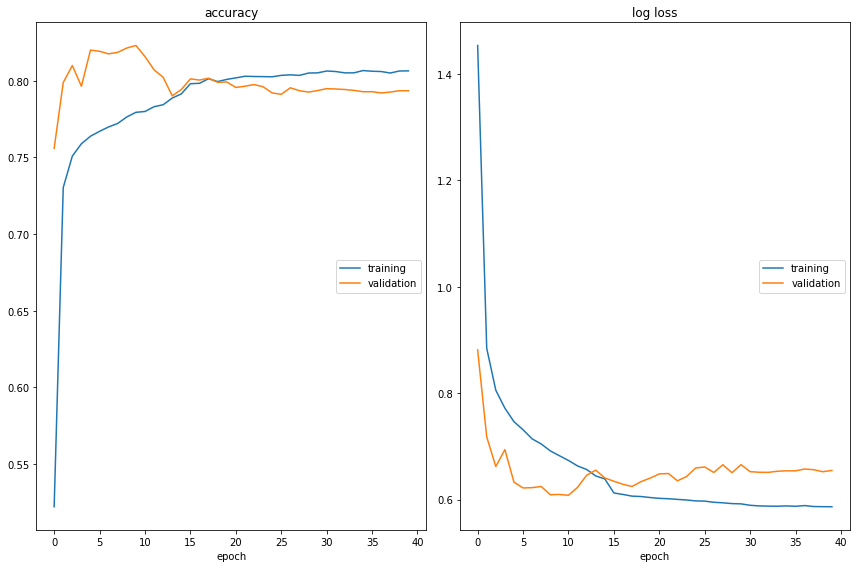

accuracy
	training         	 (min:    0.522, max:    0.807, cur:    0.806)
	validation       	 (min:    0.756, max:    0.823, cur:    0.793)
log loss
	training         	 (min:    0.587, max:    1.453, cur:    0.587)
	validation       	 (min:    0.608, max:    0.881, cur:    0.655)


In [64]:
best_model = train_model(model, criterion, optimizer, scheduler, 40)